Introduction:

Horse racing is a $402.3 Billion industry (GlobalNewsWire), and betting on race outcomes is both an integral part of the races and a possibly lucrative 
profession. Thus, we are interested in accurately predicting horse race outcomes in order to maximize expected profits. Our dataset consists of multiple csv files - one for each year between 1990 and 2022 for both the horses and the races(track condition). For example, the horses_1990.csv file contains features such as race id, horse name, age, isFav (the favorite horse to win), and the jockey name. The races_1990.csv contains features such as race id, course, time of race, date, and track condition. 

In this project we mostly used the numeric features to avoid having to do too much data cleaning, but we still used some categorical features such as track condition to partition the data. We used a fully connected pairwise neural-net and a pairwise logistic regression model where we inputted 9 features for two horses (totalling 18 inputs) and the output was the probability of one horse beating the other (then taking the argmax to get our predicted horse winner). 

Our experimental question is: Will our specific pairwise fully-connected neural network outperform a pairwise logistic regression model?

In [14]:
#Import packages
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from multiprocessing import Pool
from torch.utils.data import random_split
from pandarallel import pandarallel

In [15]:
#Enable CUDA if possible
device = "cuda" if torch.cuda.is_available() else "cpu"
device
print("Pytorch CUDA Version is ", torch.version.cuda)

cuda_id = torch.cuda.current_device()
print("Name of the current CUDA device: ", torch.cuda.get_device_name(cuda_id))

Pytorch CUDA Version is  11.8
Name of the current CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [16]:
train = False

In [17]:
%%script false --no-raise-error

# Read in all data with Pandas
race_id = ['rid']
num_runners = ['runners']
horse_label = ['position']
horse_preds = ['age', 'decimalPrice', 'isFav', 'weightLb',
               'overWeight', 'outHandicap', 'RPR', 'TR', 'OR']
condition = ['condition']
pre_process_vars = ['weightSt']

def read_race(filename):
    race_csv = pd.read_csv(filename,
                           usecols=race_id + condition)
    return race_csv
    
def read_horse(filename):
    horse_csv = pd.read_csv(filename,
                            usecols=race_id + num_runners + horse_label +
                                    horse_preds + pre_process_vars)
    horse_csv.fillna(0, inplace=True)
    return horse_csv

race_files = os.path.join("archive/races_*.csv")
horse_files = os.path.join("archive/horses_*.csv")

race_file_list = glob.glob(race_files)
horse_file_list = glob.glob(horse_files)

race_csv = pd.concat(map(read_race, race_file_list),
                     ignore_index=True)
horse_csv = pd.concat(map(read_horse, horse_file_list),
                      ignore_index=True)

horse_csv['weightLb'] += horse_csv['weightSt']*14
horse_csv.drop(columns=pre_process_vars, inplace=True)


Couldn't find program: 'false'


In [18]:
%%script false --no-raise-error

#Group into racetrack conditions
race_conds = ['Soft', 'Good To Firm', 'Good', 'Standard', 'Yielding',
              'Good To Soft','Heavy', 'Good To Yielding', 'Firm', 'Yielding To Soft',
              'Fast', 'Soft To Heavy', 'Very Soft', 'Standard To Slow']

def get_cond_data(cond):
    return horse_csv[horse_csv.rid.isin(race_csv[race_csv.condition == cond].rid)]

conds_data = list(map(get_cond_data, race_conds))


Couldn't find program: 'false'


In [19]:
%%script false --no-raise-error

#Pre-processing data
#Note: This took 6min, 21.3s. Do not recommend running, CPU died
#Written to CSV below, load that instead.
cols_to_norm = ['age', 'decimalPrice', 'weightLb', 'RPR', 'TR', 'OR']

#https://repositorium.sdum.uminho.pt/bitstream/1822/24678/1/CVENN.pdf
def adjust_label(race_data):
    label = 1/race_data['position']
    race_data['position'] = (label - label.min()) / (label.max() - label.min())
    race_data['position'] = 2.71828**race_data['position']
    race_data['position'] /= race_data['position'].sum()
    return race_data

def process_data(data):
    pandarallel.initialize()
    data.loc[:,cols_to_norm] = data.loc[:,cols_to_norm].parallel_apply(lambda col: (col - col.mean()) / (col.std()))
    return data.groupby(race_id).parallel_apply(adjust_label)

for i in range(len(conds_data)):
    conds_data[i] = process_data(conds_data[i])

Couldn't find program: 'false'


In [20]:
%%script false --no-raise-error

#Write this abominable data to the archive file with horses and races data
#This also took far too long: 4min, 14s
for i in range(len(race_conds)):
    conds_data[i].to_csv(f"archive/{race_conds[i]}.csv", index=False)

Couldn't find program: 'false'


In [21]:
#Read in pre-processed data
race_conds = ['Soft', 'Good To Firm', 'Good', 'Standard', 'Yielding',
              'Good To Soft','Heavy', 'Good To Yielding', 'Firm', 'Yielding To Soft',
              'Fast', 'Soft To Heavy', 'Very Soft', 'Standard To Slow']

cond_file_list = [f"archive/{race_conds[13]}.csv"]
conds_data = list(map(pd.read_csv, cond_file_list))

In [22]:
#Load entire dataset via Pytorch
class HorseDataset(Dataset):
    def __init__(self, data):
        def pad_tensor(data, nrow):
            import torch
            data = torch.tensor(data.values)
            padded_tensor = torch.zeros(nrow, data.size(dim=1), 1)
            padded_tensor[:data.size(dim=0),:,0] = data
            return padded_tensor

        self.runnners_idx = data.columns.get_loc('runners')
        self.label_idx = data.columns.get_loc('position')
        self.race_idx = data.columns.get_loc('rid')
        self.preds_idx = [i[0] for i in (~pd.DataFrame(range(len(data.columns))).isin([self.runnners_idx, self.label_idx, self.race_idx])).values.tolist()]
        tensor_nrow = data.iloc[:,self.runnners_idx].max()

        pandarallel.initialize()
        self.df = data.groupby('rid').parallel_apply(lambda df: pad_tensor(df, tensor_nrow))
        self.df = torch.cat(self.df.tolist(), dim=2).cuda()

    def __len__(self):
        return self.df.size(dim=2)

    def __getitem__(self, idx):
        group = self.df[:,:,idx]
        nrow = int(group[0,self.runnners_idx])
        group = group[torch.randperm(nrow)[:2],:]
        preds = group[:,self.preds_idx]
        labels = group[:,self.label_idx]
        labels = labels / torch.sum(labels)
        
        return preds, labels

In [23]:
#Set up dataloaders
test_split = 0.2
batch_size = 1

def horse_split(dataset):
    dataset_size = len(dataset)
    test_size = int(np.floor(dataset_size * test_split))
    return random_split(dataset,
                        [dataset_size - test_size, test_size])

def horse_loader(dataset):
    return DataLoader(dataset, batch_size=batch_size,
                      shuffle=True)

In [24]:
#Set up dataloaders:
#SlowAF but necessary (4min, 4.5s)
horse_dataset = [HorseDataset(conds_data[0])]
horse_dataset = [horse_split(cond) for cond in horse_dataset]
train_dataset = [cond[0] for cond in horse_dataset]
test_dataset = [cond[1] for cond in horse_dataset]
train_dataloader = [horse_loader(cond) for cond in train_dataset]
test_dataloader = [horse_loader(cond) for cond in test_dataset]

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Methods:

Our first model is a pairwise fully-connected neural network. 


In [25]:
#Neural Net from scratch
class HorsePairWiseNet(nn.Module):
    def __init__(self):

        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(18, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
            #nn.Linear(18, 1)
        )

        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(1, 18)
        x = self.linear_stack(x)
        prob = self.Sigmoid(x)
        return prob

In [26]:
#Neural Net from scratch
class HorseLogistic(nn.Module):
    def __init__(self):

        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(18, 1)
        )

        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(1, 18)
        x = self.linear_stack(x)
        prob = self.Sigmoid(x)
        return prob

In [27]:
#Training Util
def createTrainingUtils(model, i):
    '''Constructs the utilities that will be used to train the input model
    
    Note: if you initialize a PyTorch optimizer object with a specific model's parameters,
    then specific model's parameters will be updated during training. If your model is not training, 
    it could be possible that you are optimizing the wrong set of parameters.
    
    Arguments:
        - model: a nn.Module object that will be trained and used to define the optimizer
    Returns:
        - trainDL: an nn.DataLoader object initialized with a training HotdogDataset, batch size of 16, and shuffling enabled
        - testDL: an nn.DataLoader object initialized with a testing HotdogDataset, batch size of 16, and shuffling enabled
        - lossfn: a binary-cross entropy loss object used for calculating the loss between predicted and target values
        - opt: an Adam optimizer initialized with model parameters and a learning rate of 0.001, all other values are default
    '''
    trainDL, testDL, lossfn, opt = None, None, None, None
    #start
    trainDL = train_dataloader[0]
    testDL = test_dataloader[0]
    lossfn = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    #end
    return trainDL, testDL, lossfn, opt

In [28]:
def evalDL(model, dl, lossfn):

    # figure out if the GPU is available and send model and data to it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # use torch.no_grad() context manager to prevent gradients from accumulating in evaluation 
    # and hindering training
    with torch.no_grad():
        lossSum = 0
        nCorrect = 0
        for x, y in dl:
            pred = model(x)

            # compute the loss and add to total (multiply by batch-size to make mean into sum)
            # by default, loss functions compute means of losses over batches
            lossSum += lossfn(pred, y[0,0].view(1,1))

            # compute the number of correct and update
            predictions = torch.where(pred > 0.5, 1, 0)
            truth = torch.where(y[0,0].view(1,1) > 0.5, 1, 0)
            nCorrect += torch.sum(predictions == truth)

        numSamples = len(dl.dataset)
        avgLoss = lossSum / numSamples
        acc = nCorrect / numSamples
    return avgLoss.item(), acc.item()

def evaluate(model, trainDL, validDL, lossfn):
    trainLoss, trainAcc = evalDL(model, trainDL, lossfn)
    validLoss, validAcc = evalDL(model, validDL, lossfn)
    return trainLoss, trainAcc, validLoss, validAcc

In [29]:
def train(model, trainDL, validDL, lossfn, opt, epochs=10):
    '''Trains model and returns training and validation statistics
    
    Arguments:
        - model: nn.Module object whose parameters will be updated
        - trainDL: the nn.DataLoader object for the training dataset
        - validDL: the nn.DataLoader for the validation dataset
        - lossfn: a torch.nn loss function object used to evaluate how correct the model's predictions are
        - opt: a torch.optim.Optimizer object used for updating the model's parameters
        - epochs: the number of epochs to train for
    Returns:
        - model: the model after performing training and updating it's parameters
        - trainLosses: list s.t. trainLosses[i] = average loss on training dataset before epoch i
        - trainAccs: list s.t. trainAccs[i] = prediction accuracy on training dataset after epoch i
        - validLosses: list s.t. validLosses[i] = average loss on validation dataset after epoch i
        - validAccs: list s.t. validAccs[i] = prediction accuracy on validation dataset after epoch i
    '''

    trainLosses = []
    trainAccs   = []
    validLosses = []
    validAccs   = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # evaluate model without any training
    trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, lossfn)
    trainLosses.append(trainLoss)
    trainAccs.append(trainAcc)
    validLosses.append(validLoss)
    validAccs.append(validAcc)
    print(f"Initial Model: train-loss={trainLoss:<4.2f} train-acc={trainAcc:<4.2f} valid-loss={validLoss:<4.2f} valid-acc={validAcc:<4.2f}")
    
    # replace the '...' with a line to send the model to the appropriate machine 
    # (look at evalDL on how to do this)
    model.to(device)

    for e in range(epochs):
        for X, y in trainDL:
            # START STUDENT SOLUTION ======================================================
            # 1. send data to the appropriate device
            # 2. compute prediction and loss (forward pass)
            # 3. perform the backpropagation & gradient descent (backward pass)
            pred = model(X)

            loss = lossfn(pred, y[0,0].view(1,1))
            opt.zero_grad()
            loss.backward()
            opt.step()
            # END STUDENT SOLUTION ======================================================


        trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, lossfn)
        trainLosses.append(trainLoss)
        trainAccs.append(trainAcc)
        validLosses.append(validLoss)
        validAccs.append(validAcc)
        print(f"Epoch {e:>4d}: train-loss={trainLoss:<4.2f} train-acc={trainAcc:<4.2f} valid-loss={validLoss:<4.2f} valid-acc={validAcc:<4.2f}")

    return model, trainLosses, trainAccs, validLosses, validAccs

In [30]:
def plotStatistics(epochs, trainLosses, trainAccs, validLosses, validAccs):
    fig, axes = plt.subplots(1,2)
    xdata = np.arange(epochs+1)
    
    # plot the losses
    axis = axes[0]
    axis.plot(xdata, trainLosses, label="Train")
    axis.plot(xdata, validLosses, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Average Loss")
    axis.set_title(f"Loss")
    axis.grid()
    axis.legend()
    
    # plot the accuracies
    axis = axes[1]
    axis.plot(xdata, trainAccs, label="Train")
    axis.plot(xdata, validAccs, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Accuracy")
    axis.set_title(f"Accuracy")
    axis.grid()
    axis.legend()

In [31]:
def trainAndPlot(i):
    '''Train the model and display the training and validation statistics
    
    1. initialize the HotdogMobileNet model (according to whether we are using the pretrained weights)
    2. initialize the training utilities such as the DataLoaders, loss function, and optimizer
    3. train the model for 10 epochs
    4. plot the statistics collected over training
    
    Arguments:
        - pretrained: whether MobileNet model will use pre-trained weights or not
    '''
    model = HorsePairWiseNet()
    trainDL, testDL, lossfn, opt = createTrainingUtils(model, i)
    model, trainLosses, trainAccs, validLosses, validAccs = train(model, trainDL, testDL, lossfn, opt, 10)
    plotStatistics(10, trainLosses, trainAccs, validLosses, validAccs)
    return model


In [32]:
def trainAndPlotLogistic(i):
    '''Train the model and display the training and validation statistics
    
    1. initialize the HotdogMobileNet model (according to whether we are using the pretrained weights)
    2. initialize the training utilities such as the DataLoaders, loss function, and optimizer
    3. train the model for 10 epochs
    4. plot the statistics collected over training
    
    Arguments:
        - pretrained: whether MobileNet model will use pre-trained weights or not
    '''
    model = HorseLogistic()
    trainDL, testDL, lossfn, opt = createTrainingUtils(model, i)
    model, trainLosses, trainAccs, validLosses, validAccs = train(model, trainDL, testDL, lossfn, opt, 10)
    plotStatistics(10, trainLosses, trainAccs, validLosses, validAccs)

    return model

Initial Model: train-loss=0.70 train-acc=0.52 valid-loss=0.70 valid-acc=0.50
Epoch    0: train-loss=0.68 train-acc=0.89 valid-loss=0.68 valid-acc=0.88
Epoch    1: train-loss=0.68 train-acc=0.89 valid-loss=0.68 valid-acc=0.89
Epoch    2: train-loss=0.68 train-acc=0.89 valid-loss=0.68 valid-acc=0.90
Epoch    3: train-loss=0.68 train-acc=0.89 valid-loss=0.68 valid-acc=0.90
Epoch    4: train-loss=0.68 train-acc=0.91 valid-loss=0.68 valid-acc=0.90
Epoch    5: train-loss=0.68 train-acc=0.90 valid-loss=0.68 valid-acc=0.92
Epoch    6: train-loss=0.68 train-acc=0.89 valid-loss=0.68 valid-acc=0.89
Epoch    7: train-loss=0.68 train-acc=0.91 valid-loss=0.68 valid-acc=0.90
Epoch    8: train-loss=0.68 train-acc=0.90 valid-loss=0.68 valid-acc=0.91
Epoch    9: train-loss=0.68 train-acc=0.91 valid-loss=0.68 valid-acc=0.90


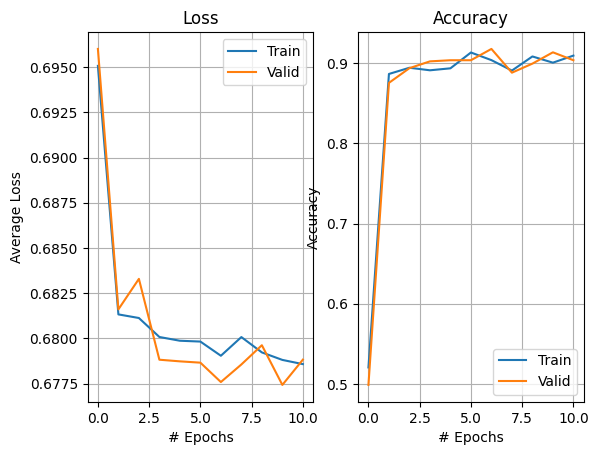

In [33]:
if train:
    for i in [13]:
        modelNN = trainAndPlot(i)
        torch.save(modelNN, f"archive/{race_conds[i]}_NN.pt")

Initial Model: train-loss=0.76 train-acc=0.40 valid-loss=0.75 valid-acc=0.39
Epoch    0: train-loss=0.68 train-acc=0.85 valid-loss=0.68 valid-acc=0.83
Epoch    1: train-loss=0.68 train-acc=0.86 valid-loss=0.68 valid-acc=0.85
Epoch    2: train-loss=0.68 train-acc=0.87 valid-loss=0.68 valid-acc=0.88
Epoch    3: train-loss=0.68 train-acc=0.85 valid-loss=0.68 valid-acc=0.85
Epoch    4: train-loss=0.68 train-acc=0.87 valid-loss=0.68 valid-acc=0.89
Epoch    5: train-loss=0.68 train-acc=0.85 valid-loss=0.68 valid-acc=0.84
Epoch    6: train-loss=0.68 train-acc=0.87 valid-loss=0.68 valid-acc=0.85
Epoch    7: train-loss=0.68 train-acc=0.87 valid-loss=0.68 valid-acc=0.86
Epoch    8: train-loss=0.68 train-acc=0.84 valid-loss=0.68 valid-acc=0.86
Epoch    9: train-loss=0.68 train-acc=0.88 valid-loss=0.68 valid-acc=0.88


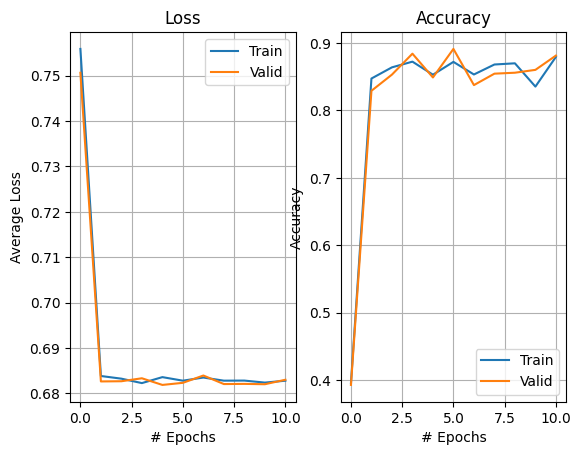

In [34]:
if train:
    for i in [13]:
        modelLogistic = trainAndPlotLogistic(i)
        torch.save(modelLogistic, f"archive/{race_conds[i]}_Logistic.pt")

In [39]:
if not train:
    for i in [13]:
        modelNN = torch.load(f"archive/{race_conds[i]}_NN.pt")
    trainDL, validDL, lossfn, opt = createTrainingUtils(modelNN, i)
    trainLoss, trainAcc = evalDL(modelNN, trainDL, lossfn)
    validLoss, validAcc = evalDL(modelNN, validDL, lossfn)
    plotStatistics(10, [trainLoss], trainAccs, validLosses, validAccs)

TypeError: 'bool' object is not callable

In [32]:
if not train:
    for i in [13]:
        model = torch.load(f"archive/{race_conds[i]}_Logistic.pt")
    trainDL, testDL, lossfn, opt = createTrainingUtils(modelLogistic, i)
    model, trainLosses, trainAccs, validLosses, validAccs = train(modelLogistic, trainDL, testDL, lossfn, opt, 10)
    plotStatistics(10, trainLosses, trainAccs, validLosses, validAccs)

Citation/References:
evalDL(), evaluate(), train(), plotStatistics(), createTrainingUtils(), and trainAndPlot() have been
taken from homework 7

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
This tutorial helped us create the structure for the neural network

https://www.globenewswire.com/en/news-release/2023/04/04/2640319/0/en/Global-Horse-Racing-Market-Size-to-Surpass-793-9-Bn-Growth-by-2030-Exhibit-a-CAGR-of-8-89-Equestrian-Industry-Analysis-Comprehensive-Study.html#:~:text=The%20global%20horse%20racing%20market,dating%20back%20to%20ancient%20times.
Used for introduction